In [1]:
import spacy
import numpy as np
import string
import re
import pandas as pd
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
nlp = spacy.load('en_vectors_web_lg')

In [3]:
X = pd.read_csv("./data/hate.csv", delimiter=",", dtype='unicode')

In [4]:
def train(X, y, b0=None, W0=None, b=None, W=None, b2=None, W2=None, eta=1):
    D = 50
    K = 2
    # initialize parameters randomly
    h = 50 # size of hidden layer
    if b0 is None:
        W0 = 0.01 * np.random.randn(300,50)
        b0 = np.zeros((1,50))
        W = 0.01 * np.random.randn(D,h)
        b = np.zeros((1,h))
        W2 = 0.01 * np.random.randn(h,K)
        b2 = np.zeros((1,K))

    # some hyperparameters
    step_size = eta
    reg = 1e-3 # regularization strength
    
    num_examples = len(y)
    # pooling loop
    kt = np.empty((len(y), 300))
    for i in range(len(y)):
        # word embeddings -> Max pooling / Average pooling -> 1-layer MLP -> ReLu -> Fully connected softmax
        # word embed
        Xi = nlp(X[i].decode('utf-8'))
        t = len(Xi)
        wt = map(lambda x: x.vector, Xi)
        # ReLu
        zt = np.maximum(0, wt)
        # max pooling / Average pooling
        #mt = np.max(zt, axis=0)
        at = np.mean(zt, axis=0)
        # concat
        kt[i, :] = at #np.append(mt, at)
        
    # gradient descent loop
    for j in xrange(1): 
        # evaluate class scores, [N x K]
        hidden_layer0 = np.dot(kt, W0) + b0
        hidden_layer = np.maximum(0, np.dot(hidden_layer0, W) + b) # note, ReLU activation
        scores = np.dot(hidden_layer, W2) + b2

        # compute the class probabilities
        exp_scores = np.exp(scores)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True) # [N x K]

        # compute the loss: average cross-entropy loss and regularization
        correct_logprobs = -np.log(probs[range(num_examples),y])
        data_loss = np.sum(correct_logprobs)/num_examples
        reg_loss = 0.5*reg*np.sum(W*W) + 0.5*reg*np.sum(W2*W2)
        loss = data_loss + reg_loss
        # if j % 100 == 0:
        #    print "iteration %d: loss %f" % (j, loss)
            
        # compute the gradient on scores
        dscores = probs
        dscores[range(num_examples),y] -= 1
        dscores /= num_examples
  
        # backpropate the gradient to the parameters
        # first backprop into parameters W2 and b2
        dW2 = np.dot(hidden_layer.T, dscores)
        db2 = np.sum(dscores, axis=0, keepdims=True)
        # next backprop into hidden layer
        dhidden = np.dot(dscores, W2.T)
        # backprop the ReLU non-linearity
        dhidden[hidden_layer <= 0] = 0
        # into W,b
        dW = np.dot(hidden_layer0.T, dhidden)
        db = np.sum(dhidden, axis=0, keepdims=True)
        # next backprop into hidden0 layer
        dhidden0 = np.dot(dhidden, W.T)
        # finally into W0, b0
        dW0 = np.dot(kt.T, dhidden0)
        db0 = np.sum(dhidden0, axis=0, keepdims=True)

        # add regularization gradient contribution
        dW2 += reg * W2
        dW += reg * W
        dW0 += reg * W0

        # perform a parameter update
        W += -step_size * dW
        b += -step_size * db
        W2 += -step_size * dW2
        b2 += -step_size * db2
        W0 += -step_size * dW0
        b0 += -step_size * db0
    return b0, W0, b, W, b2, W2

In [5]:
def predict(X, b0, W0, b, W, b2, W2):
    num = np.shape(X)[0]
    # print X
    kt = np.empty((num, 300))
    for i in range(num):
        # word embeddings -> Max pooling / Average pooling -> 2-layer MLP -> ReLu -> Fully connected softmax
        # word embed
        Xi = nlp(X[i].decode('utf-8'))
        t = len(Xi)
        wt = map(lambda x: x.vector, Xi)
        # ReLu
        zt = np.maximum(0, wt)  #wt * (wt > 0)
        # max pooling / Average pooling
        #mt = np.max(zt, axis=0)
        at = np.mean(zt, axis=0)
        # concat
        kt[i, :] = at #np.append(mt, at)
    # evaluate class scores, [N x K]
    hidden_layer0 = np.dot(kt, W0) + b0
    # evaluate class scores, [N x K]
    hidden_layer = np.maximum(0, np.dot(hidden_layer0, W) + b) # note, ReLU activation
    scores = np.dot(hidden_layer, W2) + b2
    predicted_class = np.argmax(scores, axis=1)
    return predicted_class

In [6]:
def queue_learn(a, b, b0, w0, b1, w1, b2, w2, L, eta):
    global q_p, q_n
    y_hat = predict([a], b0, w0, b1, w1, b2, w2)
    # print y_hat[0], b
    if b == 0:
        if q_n.size == L:
            q_n[:-1] = q_n[1:]
            q_n[-1] = a
        else:
            q_n = np.append(q_n, a)
    else:
        if q_p.size == L:
            q_p[:-1] = q_p[1:]
            q_p[-1] = a
        else:
            q_p = np.append(q_p, a)
    z = np.append(q_n, q_p)
    k = np.array([0 for i in range(q_n.size)])
    k1 = np.array([1 for i in range(q_p.size)])
    k = np.append(k, k1)
    b0_new, w0_new, b1_new, w1_new, b2_new, w2_new = train(z, k, b0, w0, b1, w1, b2, w2, eta)
    s = 0
    b0 = b0 * s + b0_new * (1 - s)
    b1 = b1 * s + b1_new * (1 - s)
    b2 = b2 * s + b2_new * (1 - s)
    w0 = w0 * s + w0_new * (1 - s)
    w1 = w1 * s + w1_new * (1 - s)
    w2 = w2 * s + w2_new * (1 - s)
    return y_hat[0]

In [7]:
b=X.iloc[:,6].values
a=map(int, X.iloc[:,5].values)
a = map(lambda x : 1 if x == 0 else 0, a)
rand = np.random.permutation(len(a))

In [13]:
Ls = [50]

# results = {}
for L in Ls:
    num_incorrect = 0
    num_zero = 0
    temp = []
    temp2 = []
    salpha, nalpha = 0, 0
    res = []
    q_p = np.array(L)
    q_n = np.array(L)
    b0, w0, b1, w1, b2, w2 = train([], [])

    for i in range(len(a)):
        out = queue_learn(b[rand[i]], a[rand[i]], b0, w0, b1, w1, b2, w2, L, 1 if L < 20 else 0.3)
        num_incorrect += (out != a[rand[i]])
        num_zero += a[rand[i]] == 0
        if len(temp) == 30:
            temp[:-1] = temp[1:]
            temp[-1] = out
            temp2[:-1] = temp2[1:]
            temp2[-1] = a[rand[i]]
        else:
            temp.append(out)
            temp2.append(a[rand[i]])
        tn, fp, fn, tp = confusion_matrix(temp2, temp, labels=[0,1]).ravel()
        specificity = tn / (tn+fp)
        pre = precision_score(temp2, temp)
        rec = recall_score(temp2, temp)
        ei = 1 - f1_score(temp2, temp, average='weighted')
        salpha = ei + 0.99 * salpha
        nalpha = 1 + 0.99 * nalpha
        palpha = 1 - (salpha / nalpha)
        res.append(palpha)
        if i % 1000 == 0:
            print "Iteration: ", i, "Num incorrect: ", num_incorrect
            print palpha
    results[L] = res

/Users/jainulvaghasia/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in double_scalars


Iteration:  0 Num incorrect:  1
0.0
Iteration:  1000 Num incorrect:  140
0.8022325714859954
Iteration:  2000 Num incorrect:  382
0.7984177532383406
Iteration:  3000 Num incorrect:  667
0.8078802643973573
Iteration:  4000 Num incorrect:  929
0.8237432174297342
Iteration:  5000 Num incorrect:  1196
0.857594345267516
Iteration:  6000 Num incorrect:  1412
0.8322290403550904
Iteration:  7000 Num incorrect:  1610
0.8460694191090583
Iteration:  8000 Num incorrect:  1849
0.835252374030576
Iteration:  9000 Num incorrect:  2093
0.8178095320859492
Iteration:  10000 Num incorrect:  2360
0.8398729030113248
Iteration:  11000 Num incorrect:  2591
0.830558854607173
Iteration:  12000 Num incorrect:  2833
0.8174523307539083
Iteration:  13000 Num incorrect:  3067
0.8538443818025134
Iteration:  14000 Num incorrect:  3300
0.7951046389146448
Iteration:  15000 Num incorrect:  3518
0.8430654932284726
Iteration:  16000 Num incorrect:  3728
0.8197241345318966
Iteration:  17000 Num incorrect:  3999
0.77038323201

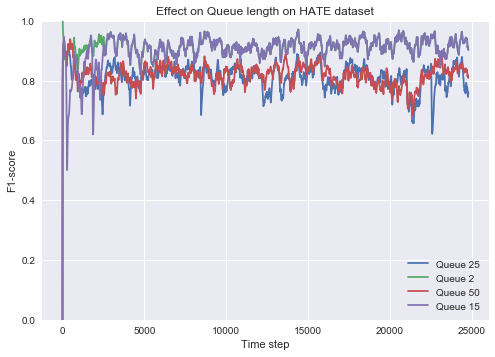

In [14]:
for k, v in results.items():
    plt.plot(v, label='Queue ' + str(k))
plt.ylim(0, 1)
plt.legend()
plt.ylabel('F1-score')
plt.xlabel('Time step')
plt.title('Effect on Queue length on HATE dataset')
plt.show()

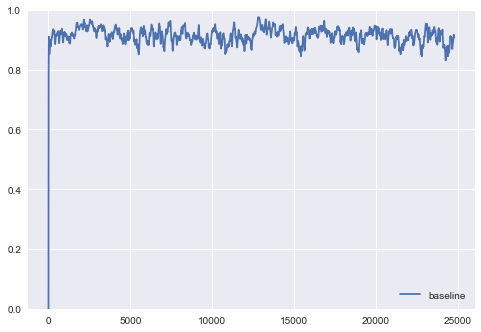

In [31]:
plt.ylim(0, 1)
plt.legend()
plt.show()